<a href="https://colab.research.google.com/github/MJSahebnasi/temporal-network-platform/blob/main/thesis_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx

from typing import List, Type
import abc

import copy

import heapq


# Events

In [2]:
class Event:
  def __init__(self, t) -> None:
    self.time = t
    
  def __repr__(self):
    return "<time:" + str(self.time) + ">"

  # will be used in heap, when selecting the earliest event
  def __lt__(self, other):
    return self.time < other.time

  @abc.abstractmethod
  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    return

class NodeEvent(Event):
  def __init__(self, t, node) -> None:
    super().__init__(t)
    self.node = node

  def __repr__(self):
    return super().__repr__()[:-1] + "-node:"+str(self.node) + ">"

class NodeEntranceEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-entrance" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    ### intentionally won't handle this scenario:
    # if self.node in dead_and_attacked_nodes:
    #   return
    ###
    sim_G.add_node(self.node)
    edges = [(self.node, i) for i in _current_neighbors(sim_G, orig_G, self.node)]
    sim_G.add_edges_from(edges)

class NodeDeathEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-death" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # might already be off or attacked
    if self.node in sim_G.nodes():
      sim_G.remove_node(self.node)
    # no matter the if, this must execute:
    dead_and_attacked_nodes.add(self.node)

class NodeAttackEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-attack" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # might already be off or dead
    if self.node in sim_G.nodes():
      sim_G.remove_node(self.node)
    # no matter the if, this must execute:
    dead_and_attacked_nodes.add(self.node)

class NodeOnEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-on" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # the node might die or get attacked while off
    if self.node in dead_and_attacked_nodes:
      return
    sim_G.add_node(self.node)
    edges = [(self.node, i) for i in _current_neighbors(sim_G, orig_G, self.node)]
    sim_G.add_edges_from(edges)

class NodeOffEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-off" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # the node might be already dead or attacked
    # instead of using "dead_and_attacked_nodes", I used "nodes()"
    #   this way consecutive offs will be handled
    if self.node in sim_G.nodes():
      sim_G.remove_node(self.node)

def _current_neighbors(sim_G, orig_G, node):
  return set.intersection(set(sim_G.nodes()), set(orig_G.neighbors(node)))

# Simulation

In [3]:
class Simulation:   

  ########################## init ##########################

  def create(self, G):
    self.orig_G = G
    self.sim_G = copy.deepcopy(G)
    self.dead_and_attacked_nodes = set() # not off nodes

    self.has_entrance_process = False
    self.has_onoff_process = False
    self.has_node_lifespan = False
    self.has_attack_process = False

    self.events = []
    # self.history = []
    # self.snapshots = []

    return self

  def with_entrance_process(self, node_entrance_times):
    ### TODO: parameter validation ###
    self.has_entrance_process = True
    self.node_entrance_times = node_entrance_times
    return self

  def with_node_onoff_process(self, node_on_times, node_off_times):
    ### TODO: parameter validation ###
    self.has_onoff_process = True
    self.node_on_times = node_on_times
    self.node_off_times = node_off_times
    return self

  def with_node_lifespans(self, node_death_times):
    ### TODO: parameter validation ###
    self.has_node_lifespan = True
    self.node_death_times = node_death_times
    return self

  def with_attack_process(self, node_attack_times):
    """
    If you don't want a node to be attacked, just set a NEGATIVE attack time for it.
    example:
    [10, -1, -1, 13]
    The 2nd and the 3rd node will not be attacked.
    """
    ### TODO: parameter validation ###
    self.has_attack_process = True
    self.node_attack_times = node_attack_times
    return self


  ########################## input validation ##########################


  def __entrance_input_validation(self):
    if len(self.node_entrance_times) != self.orig_G.number_of_nodes():
      raise ValueError('!!! len(node_entrance_times) & the number of nodes not the same !!!')

  def __onoff_input_validation(self):
    n = self.orig_G.number_of_nodes()
    if len(self.node_on_times) != n:
      raise ValueError('!!! len(node_on_times) & the number of nodes not the same !!!')
    if len(self.node_off_times) != n:
      raise ValueError('!!! len(node_off_times) & the number of nodes not the same !!!')

  def __death_input_validation(self):
    if len(self.node_death_times) != self.orig_G.number_of_nodes():
      raise ValueError('!!! len(node_death_times) & the number of nodes not the same !!!')


  def __attack_input_validation(self):
    if len(self.node_attack_times) != self.orig_G.number_of_nodes():
      raise ValueError('!!! len(node_attack_times) & the number of nodes not the same !!!')


  ########################## prepair events ##########################


  def create_entrance_events(self):

    self.__entrance_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())
    self.sim_G = nx.Graph()

    for i in range(n):
      node = nodes[i]
      e = NodeEntranceEvent(self.node_entrance_times[i], node)
      self.events.append(e)

  def create_onoff_events(self):

    self.__onoff_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())

    for i in range(n):
      node = nodes[i]
      for t in self.node_on_times[i]:
        e = NodeOnEvent(t, node)
        self.events.append(e)
      for t in self.node_off_times[i]:
        e = NodeOffEvent(t, node)
        self.events.append(e)

  def create_death_events(self):

    self.__death_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())

    for i in range(n):
      node = nodes[i]
      e = NodeDeathEvent(self.node_death_times[i], node)
      self.events.append(e)

  def create_attack_events(self):

    self.__attack_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())

    for i in range(n):
      node = nodes[i]
      t = self.node_attack_times[i]

      if t < 0:
        continue

      e = NodeAttackEvent(t, node)
      self.events.append(e)

  def prepair_events(self):
    if self.has_entrance_process:
      self.create_entrance_events()

    if self.has_onoff_process:
      self.create_onoff_events()

    if self.has_node_lifespan:
      self.create_death_events()

    if self.has_attack_process:
      self.create_attack_events()

    heapq.heapify(self.events)


  ########################## run ##########################


  def run(self):
    self.prepair_events()
    sim_time = 0
    
    ###
    # print(self.events)
    ###

    while len(self.events) > 0:
      e = heapq.heappop(self.events)
      e.execute(self.sim_G, self.orig_G, self.dead_and_attacked_nodes)
      sim_time = e.time

      print(e)
      print(self.sim_G)
      print('dead nodes', self.dead_and_attacked_nodes)
      print('nodes', self.sim_G.nodes())
      print('edges', self.sim_G.edges())
      print('----------------')

    

In [44]:
# has good things in it
# like death after attack
g = nx.erdos_renyi_graph(n=50,p=0.7)
ent = [0, 1, 2]
dth = [10, 50, 55]
atk = [8, -1, -1]
off = [[3], [10, 20], []]
on  = [[5], [12], []]

print(g)
print(g.nodes())
print(g.edges())
print('-------')

s = Simulation().create(g).with_entrance_process(ent).with_node_lifespans(dth).with_attack_process(atk).with_node_onoff_process(on, off)
# res = s.run()

Graph with 50 nodes and 885 edges
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 19), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 28), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 40), (0, 41), (0, 43), (0, 44), (0, 47), (0, 48), (0, 49), (1, 2), (1, 4), (1, 5), (1, 6), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 16), (1, 17), (1, 18), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 35), (1, 37), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 49), (2, 4), (2, 7), (2, 11), (2, 13), (2, 14), (2, 15), (2, 17), (2, 19), (2, 21), (2, 22), (2, 24), (2, 27), (2, 29), (2, 30

# diagram package

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_degree_distribution(G):
  degree_distrib = nx.degree_histogram(G)
  x = range(len(degree_distrib))

  plt.figure()

  plt.plot(x, degree_distrib, marker='o')
  title = 'degree distribution'
  plt.title(title)
  plt.grid()
  plt.xticks(x)
  plt.yticks(np.arange(np.min(degree_distrib), np.max(degree_distrib) + 1, 1))
  plt.xlabel('degree')
  plt.ylabel('nodes count')
  plt.tick_params(labelrotation=45)

  plt.show()
  

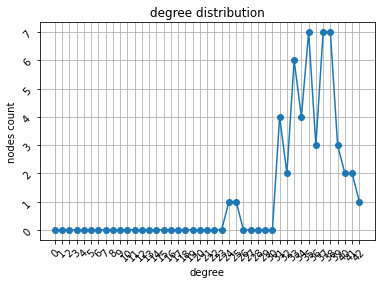

In [48]:
plot_degree_distribution(g)